# Simulating Wireless Interference with loraplan

Sander Aarts, 2022.


# Introduction
LoRa networks suffer from _wireless interference_. If many concurrent transmissions arrive at a receiver, the receier is unlikely to successfully process all arrivals. This leads to _packets loss_, and an overall lower throughput of the network. As network planners it is our job to ensure that packet loss due to interference is within acceptable levels. To do so, it is useful to estimate the packet error rate for various network designs. Testing large networks with thousands of devices in the real world is difficult, costly, and distruptive. Instead, we turn to _simulation_, where running experiments is easy, cheap, and does not disrupt wireless traffic in the real worls. By making our simulations realistic (where it matters) we can inform real-world network design based on computer simulations.

On a high level, interference simulations take three main components:
 1. A _network model_ that describes how wireless traffic is generated
 2. An _interference model_ that estimates which transmissions are received, and which are lost
 3. Analysis of output from generating traffic and applying the interference mdoel

In this notebook we discuss each point in turn, and show how the `loraplan.interefence`-module is used.

## Contents
This notebook showcases the `loraplan.interference` module from the point of view of interference simulations. The notebook includes the following.
- Setting up a simulate LoRa network, and a LoRa `TrafficGenerator`
    - Choosing the type of network to simulate
    - Choosing distributions from `loraplan.distributions`.
- Generating and understadning LoRa `Traffic`
- Interference models
- Running simulations
- Analyzing simulated output

# Loading packages and modules

In [43]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [5]:
# set path to where modules are
sys.path.insert(0, os.path.abspath('../src/loraplan/'))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
# load modules
import interference as lpf
import distributions as lpd

# Generating wireless traffic with a simulated network

## An abstract approach: A distirbution over traffic

Ultimately, a network model's main purpose is to generate wireless `Traffic`. Here, we take a more abstract route and directly define a probability distribution over `Traffic`-objects. We do so by specifying distributions over critical wireless parameters:
1. `ArrivalProcess`: A distribution (process) over packet arrival times.
2. A distribution over channels
3. A distribution over spreading factors
4. A distribution over airtimes
5. A distribution over (received) power

### 1. An arrival process

Let's specify how packets arrive by instantiating an `ArrivalProcess`.
- First specify a `TimeWindow` with a `buffer`
- Next equip the`TimeWindow` with an `ArrivalProcess`

#### Specify a timeWindow

In [134]:
# make a time window [0, 10] with a buffer of ±5 seconds.
window = lpd.TimeWindow(0, 10, buffer=5)

print(window)
print(f"\n \tThe window has {window.length = } because this includes buffer {window.buff = }.")

TimeWindow(0, 10, buffer=5)

 	The window has window.length = 20 because this includes buffer window.buff = 5.


#### Specify an ArrivalProcess

With our `TimeWindow` we can proceeed by defining an `ArrivalProcess`.

Let try a `PoissonArrivalProcess` by specifying an arrival rate (packets / second).

In [135]:
# make a Poisson arrival proces
arrivals = lpd.PoissonArrivals(timeWindow=window, rate = 1)

print(arrivals)

HomogeneousPoissonArrivals(TimeWindow(0, 10, buffer=5), rate=1)


#### Sampling arrival times
An `ArrivalProcess` lets us sample arrivals - both their number and time over the `TimeWindow` using `sample()`.

We can visualize the arrivals. Try sampling a few times - note that the number of arrivals as well as the arrival times vary

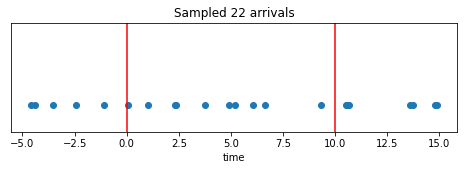

In [136]:
# sample arrivals
arr = arrivals.sample()

nObs = arr[0].shape[0]

# plot arrivals
fig, ax = plt.subplots(figsize=(8, 2))
plt.title(f"Sampled {nObs} arrivals")
ax.scatter(arr[0], np.zeros(arr[0].shape[0]))
ax.set_ylim([-1,1])
ax.set_ylim([window.tMin - window.buff, window.tMax + window.buff])
ax.set_xlabel("time")
ax.set_yticklabels([])
ax.set_yticks([])
plt.axvline(x=window.tMin, c='r')
plt.axvline(x=window.tMax, c='r')
plt.show()

### 2. Distributions over wireless parameters

Next, we simply specify a distribution over the essential LoRaWAN parameters. To help us keep track of which parameters to specify distributions over, we can refer to the `lpf.LoRaParameters` object.

We will also make use of these parameters when computing airtimes.

In [137]:
# specify a LoRaWAN-parameters object
wan = lpf.LoRaParameters(nChannels=4)

print(wan)

A LoRa Parameters object with params:
	 nChannels: 4
	 freq: 915
	 bw: 125
	 sf: [7, 8, 9, 10]
	 overhead: 13
	 maxPow: 30
	 codingRate: 4/5
	 dwellTime: 400
	 dutyCycle: None


In [138]:
# specify a sperading factor distirbution
channelDist = lpd.Choice(wan.nChannels)  # unifom when no parameters specified
print(channelDist)

DiscreteDistribution({'a': 4, 'p': None, 'replace': True, 'seed': None})


In [139]:
# specify a sperading factor distirbution
spreadingDist = lpd.Choice(wan.sf, p=[0.1, 0.2, 0.3, 0.4])
print(spreadingDist)

DiscreteDistribution({'a': [7, 8, 9, 10], 'p': [0.1, 0.2, 0.3, 0.4], 'replace': True, 'seed': None})


In [140]:
# a power distribution
powerDist = lpd.Normal(loc=-80, scale=10)
print(powerDist)

NormalDistribution({'loc': -80, 'scale': 10, 'seed': None})


In [141]:
class TrafficGenerator(ABC):
    """
    ABC for traffic-generating objects.
    
    Typical ``TrafficGenerators`` are  compositions. Often, a generator
    takes an ``ArrivalProcess`` and a ``ParameterDistribution``.
    ``Traffic``-objects are generated by sampling arrivals and equipping
    these with sampled parameters. Dependence between arrivals and
    parameters should also be supported.
    
    Notes
    -----
    ``Traffic``-objects are market point processes. As such, each sample
    has a variable number of observations. This makes it difficult to
    store samples as arrays. Instead, a sample of ``size = k`` is a list
    of length k, in which each entry is an array of shape ``(nObs[k], d)``
    where ``d`` is the number of parameters. Due to this, much of the code
    includes list comprehensions.
    """
    
    @abstractmethod
    def sample(self):
        pass
    
    def __call__(self, seed=None, **kwargs):
        """
        Get a sample.
        """
        return self.sample(seed=None, **kwargs)

In [144]:
class IndependentLoRaGenerator(TrafficGenerator):
    """
    Composition of a TimeWindow, LoRaParameters, and (parameter) Distributions.

    The ``IndependentLoRaGenerator`` is a ``TrafficGenerator``-object for when
    parameters are distributed independently of each other and of the arrivals.
    This object's main function is to collect various model components in one
    place. In particular, an ``ArrivalProcess``, ``LoRaParameters`` and
    ``Distribution``-objects over the various wireless parameters.
    
    
    Attributes
    ----------
    arrivalProcess : ArrivalProcess
        An arrival process for generating nr. of packets and arrival times.
        
    loraParams : LoRaParameters
        A LoRaParameters-object from which essential parameters are pulled.
    
    channelDist : Distribution
        A distribution over LoRa channels
    
    spreadingDist : Distribution
        A distirbution over spreading factors
    
    payloadDist : Distribution
        A distribution over payload length in bytes.
        
    powerDist : Distribution
        A distribution over received transmission power.
        If transmissions are equipped with link parameters
        one can change this for `transmittedPower - pathLoss`.
    
    """
    
    def __init__(self, arrivalProcess, loraParams, channelDist,
                 spreadingDist, payloadDist, powerDist):
        """
        Initialize LoRa traffic generator with independent parameter distributions.
        """
        
        self.arrivals = arrivalProcess
        self.params = loraParams
        self.channelDist = channelDist
        self.spreadingDist = spreadingDist
        self.payloadDist = payloadDist
        self.powerDist = powerDist
        
    
    def sample(size=None, seed=None):
        """
        Sample LoRa wireless traffic.
        
        The sample first queries the ArrivalProces for the number of packets and
        their individual arrival times. Given the number of packets nObs, the
        remaining distributions are sampled to compile a matrix of parameter data.
        The airtime is computed last using ``interference.airtime()`` and stored
        network-level parameters ``self.parameters`` as well as packet-level parameters
        such as the spreading factor ``SF`` and ``payload``.
        
        See Also
        --------
        ``lp.interference.airtime``
        
        """
        N = size
        
        arrivals = self.arrivals.sample(size=N)
        
        nObs = [arr.shape[0] for arr in arrivals]
        
        # sample prameters
        channels = [self.channelDist(size=n) for n in nObs]
        spreadings = [self.spreadingDist(size=n) for n in nObs]
        powers = [self.powerDist(size=n) for n in nObs]
        payloads = [self.paylodDist(size=n) for n in nObs]
        
        # compute airtimes
        cr = self.parameters.codingRate
        bw = self.parameters.bw
        oh = self.parameters.overhead
        
        airtimes = [airtime(payloads[i]+oh, spreadings[i], bw=bw, codingRate=cr) for i in range(N)]
        
        # make traffic-objects
        traffics = [Traffic(nObs[i], arrivals[i], airtimes[i],
                            channels[i], spreadings[i], powers[i]) for i in range(N)]
        
        return traffics

# Modeling wireless interference

# Simulation experiments and output analysis